In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                           download=True, transform=transform)

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_dim = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)
        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [12]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(DEVICE)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(data)
        loss = loss_function(data, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/30, Loss: 178.5274
Epoch 2/30, Loss: 131.0387
Epoch 3/30, Loss: 119.9630
Epoch 4/30, Loss: 115.1232
Epoch 5/30, Loss: 111.9784
Epoch 6/30, Loss: 110.0477
Epoch 7/30, Loss: 108.7512
Epoch 8/30, Loss: 107.6095
Epoch 9/30, Loss: 106.8335
Epoch 10/30, Loss: 105.9559
Epoch 11/30, Loss: 105.3936
Epoch 12/30, Loss: 104.7807
Epoch 13/30, Loss: 104.2883
Epoch 14/30, Loss: 104.0266
Epoch 15/30, Loss: 103.5921
Epoch 16/30, Loss: 103.2866
Epoch 17/30, Loss: 102.9696
Epoch 18/30, Loss: 102.7797
Epoch 19/30, Loss: 102.5206
Epoch 20/30, Loss: 102.3022
Epoch 21/30, Loss: 102.1662
Epoch 22/30, Loss: 101.9019
Epoch 23/30, Loss: 101.7883
Epoch 24/30, Loss: 101.6770
Epoch 25/30, Loss: 101.5053
Epoch 26/30, Loss: 101.4578
Epoch 27/30, Loss: 101.1730
Epoch 28/30, Loss: 101.0856
Epoch 29/30, Loss: 101.1015
Epoch 30/30, Loss: 100.9687


In [13]:
model.eval()

with torch.no_grad():

    gaussian_noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    gaussian_images = decoder(gaussian_noise)

    poisson_noise = torch.poisson(torch.ones(batch_size, latent_dim)).to(DEVICE)
    poisson_images = decoder(poisson_noise)

    uniform_noise = torch.rand(batch_size, latent_dim).to(DEVICE)
    uniform_images = decoder(uniform_noise)

In [10]:
def show_images(images, title, idx=10):
    images = images.view(batch_size, 28, 28).cpu()
    fig, axes = plt.subplots(1, idx, figsize=(15, 2))
    fig.suptitle(title)
    for i in range(idx):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

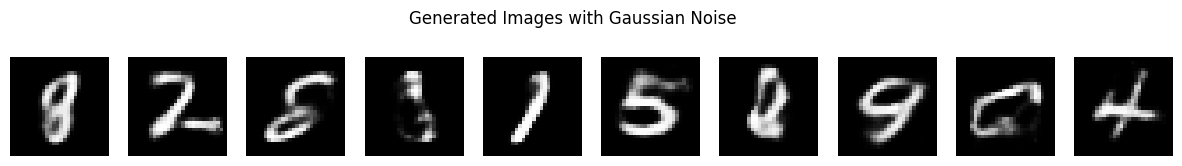

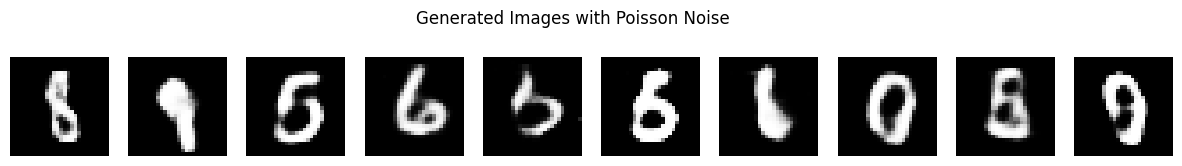

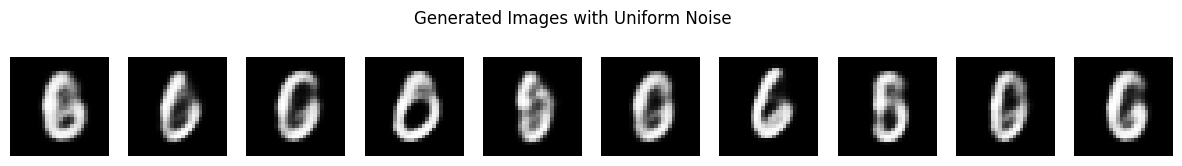

In [14]:
show_images(gaussian_images, "Generated Images with Gaussian Noise")
show_images(poisson_images, "Generated Images with Poisson Noise")
show_images(uniform_images, "Generated Images with Uniform Noise")